In [37]:
import pandas as pd
import sqlalchemy
import pickle
import os
import matplotlib.pyplot as plt

In [2]:
def pickle_file(obj, path):
    file = open(path, 'ab')
    pickle.dump(obj, file)
    file.close()

def load_pickle(path):
    file = open(path, 'rb')
    obj = pickle.load(file)
    file.close()
    return obj

# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
def unique_check(df):
    (df
    .groupby(["C/A", "UNIT", "SCP", "STATION", "DATETIME"])
    .ENTRIES.count()
    .reset_index()
    .sort_values("ENTRIES", ascending=False)).head(5)
    
# pickle_file(stations, 'station_list')
def get_daily_counts(row, max_counter, max_difference, entry=True):
    col_current1 = "ENTRIES" 
    col_prev1 = "PREV_ENTRIES"
    col_current2 = "EXITS"
    col_prev2 = "PREV_EXITS"

    counter1 = row[col_current1] - row[col_prev1]
    counter2 = row[col_current2] - row[col_prev2]
    if counter1 < 0:
        # Maybe counter is reversed?
        counter1 = -counter1
    if counter2 < 0:    
        # Maybe counter is reversed?
        counter2 = -counter2
    if counter1 > max_counter:
        # Maybe counter was reset to 0? 
        print(row[col_current1], row[col_prev1], end='\r')
        counter1 = min(row[col_current1], row[col_prev1])
    if counter2 > max_counter:
        # Maybe counter was reset to 0? 
        print(row[col_current2], row[col_prev2], end='\r')
        counter2 = min(row[col_current2], row[col_prev2])
    if (counter1 > max_counter) & (abs(counter1-counter2) > max_difference):
        # Check it again to make sure we're not still giving a counter that's too big
        counter1 = 0
    if (counter2 > max_counter) & (abs(counter1-counter2) > max_difference):
        # Check it again to make sure we're not still giving a counter that's too big
        counter2 = 0
    if entry:
        return counter1
    else:
        return counter2

def fix_daily_counts(row, daily_column):
    count = row[daily_column]
    if count == 0:
        i = row.name if row.name > 4 else 4
        count = df.iloc[i-4:i+4][daily_column].mean()
        print((str(i) + '\t' + str(count)), end='\r')
    return count

In [17]:
stations = pd.read_sql('''SELECT DISTINCT(STATION) FROM mta_data''',engine)
stations = stations.STATION.tolist()

In [29]:
df = pd.read_sql(f"SELECT [C/A], UNIT, SCP, STATION, LINENAME, DATE, TIME, DATE ||' '|| TIME as DATETIME, DESC, ENTRIES, EXITS FROM mta_data WHERE STATION IN {tuple(stations[:50])}",engine)
df['DATETIME'] = pd.to_datetime(df.DATETIME)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5807357 entries, 0 to 5807356
Data columns (total 11 columns):
 #   Column    Dtype         
---  ------    -----         
 0   C/A       object        
 1   UNIT      object        
 2   SCP       object        
 3   STATION   object        
 4   LINENAME  object        
 5   DATE      object        
 6   TIME      object        
 7   DATETIME  datetime64[ns]
 8   DESC      object        
 9   ENTRIES   int64         
 10  EXITS     int64         
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 487.4+ MB


In [4]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
def unique_check(df):
    (df
    .groupby(["C/A", "UNIT", "SCP", "STATION", "DATETIME"])
    .ENTRIES.count()
    .reset_index()
    .sort_values("ENTRIES", ascending=False)).head(5)

In [5]:
# Get rid of the duplicate entry
print(df.shape)
df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATETIME"], 
                          inplace=True, ascending=False)
df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATETIME"], inplace=True)
print(df.shape)

(4918351, 12)
(4918271, 12)


In [6]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATETIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATETIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-12-28 03:00:00,1
3278853,N506,R022,00-06-00,34 ST-HERALD SQ,2021-01-05 23:00:00,1
3278851,N506,R022,00-06-00,34 ST-HERALD SQ,2021-01-05 15:00:00,1
3278850,N506,R022,00-06-00,34 ST-HERALD SQ,2021-01-05 11:00:00,1
3278849,N506,R022,00-06-00,34 ST-HERALD SQ,2021-01-05 07:00:00,1


In [7]:
df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (df
                                    .groupby(["C/A", "UNIT", "SCP", "STATION","LINENAME"])["DATE", "ENTRIES", "EXITS"]
                                    .apply(lambda grp: grp.shift(1)))

/tmp/ipykernel_31306/80764136.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (df


In [7]:
# df.groupby(["C/A", "UNIT", "SCP", "STATION","LINENAME"])
df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = df.groupby(["C/A", "UNIT", "SCP", "STATION","LINENAME"])[["DATE", "ENTRIES", "EXITS"]] .shift(1)

In [9]:
df.PREV_DATE.isna().sum() 

1015

In [10]:
# Drop the rows for the earliest date in the df
df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [157]:
generate_line_density(df)
df.head()

,index,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,DATETIME,DESC,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS,DAILY_ENTRIES2,OVER_MAX,LINE_DENSITY
41536,41536,R639,R109,00-06-00,CHURCH AV,25,2022-04-29,17:00:00,2022-04-29 17:00:00,REGULAR,856501374,1578114851,04/29/2022,856501478.0,1.578115e+09,104.0,137.0,0.0,False,120.5
41535,41535,R639,R109,00-06-00,CHURCH AV,25,2022-04-29,13:00:00,2022-04-29 13:00:00,REGULAR,856501223,1578114714,04/29/2022,856501374.0,1.578115e+09,151.0,137.0,0.0,False,144.0
41534,41534,R639,R109,00-06-00,CHURCH AV,25,2022-04-29,09:00:00,2022-04-29 09:00:00,REGULAR,856501132,1578114656,04/29/2022,856501223.0,1.578115e+09,91.0,58.0,0.0,False,74.5
41533,41533,R639,R109,00-06-00,CHURCH AV,25,2022-04-29,05:00:00,2022-04-29 05:00:00,REGULAR,856501041,1578114616,04/29/2022,856501132.0,1.578115e+09,91.0,40.0,0.0,False,65.5
41532,41532,R639,R109,00-06-00,CHURCH AV,25,2022-04-29,01:00:00,2022-04-29 01:00:00,REGULAR,856501038,1578114603,04/29/2022,856501041.0,1.578115e+09,3.0,13.0,0.0,False,8.0


In [3]:
def remove_duplicates(df):
    # Get rid of the duplicate entry
    print(df.shape)
    df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATETIME"], 
                            inplace=True, ascending=False)
    df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATETIME"], inplace=True)
    print(df.shape)
def shift_drop(df):
    # #Shift Rows and Drop NA
    df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (df
                                    .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES", "EXITS"]
                                    .apply(lambda grp: grp.shift(1)))
    df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

def tally_entrances(df, max_counter = 5000):
    df['DAILY_ENTRIES'] = (df.ENTRIES - df.PREV_ENTRIES).abs()
    df['DAILY_EXITS'] = (df.EXITS - df.PREV_EXITS).abs()
    
    for x in ['ENTRIES', 'EXITS']:
        df['OVER_MAX'] = df['DAILY_'+x] > max_counter
        print(df.OVER_MAX.sum())

        
        df['DAILY_'+x] = (df['DAILY_'+x] * ~ df.OVER_MAX) + (df[[x,'PREV_'+x]].min(axis=1) * df.OVER_MAX)

        df['OVER_MAX'] = df['DAILY_'+x] > max_counter
        print(df.OVER_MAX.sum())

        df['DAILY_'+x] = (df['DAILY_'+x] * ~ df.OVER_MAX) + ((df['DAILY_'+x]* ~df.OVER_MAX).mean() * df.OVER_MAX)
        df['OVER_MAX'] = df['DAILY_'+x] > max_counter
        print(df.OVER_MAX.sum())
    df.drop('OVER_MAX', axis=1)

def generate_line_density(df):
    df['LINE_DENSITY'] = (df.DAILY_ENTRIES + df.DAILY_EXITS) / df.LINENAME.str.len()

def group_by_date(df):
    df = df[['STATION', 'LINENAME', 'DATE',
       'DAILY_ENTRIES', 'DAILY_EXITS', 'LINE_DENSITY']].groupby(['DATE','STATION', 'LINENAME']).sum()

In [4]:
path = './data_raw/'
df_list = []

for filename in os.listdir(path):

    df = load_pickle(path+filename)
    df.DATE = pd.to_datetime(df.DATE)
    print('Data Loaded')
    
    remove_duplicates(df)
    shift_drop(df)
    tally_entrances(df)
    generate_line_density(df)
    group_by_date(df)

    pickle_file(df, f"data_cleaned/{filename}")
    print(f"saved:\tdata_cleaned/{filename}\n")
    print('-_'*10)
    print('\n')

print('\n\n\n'+ '-_'*10)
print('All Done')

Data Loaded
(628953, 11)
(628832, 11)


/tmp/ipykernel_66231/3027098279.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (df


46
24
0
22
5
0
saved:	data_cleaned/mta_stations_360_400

-_-_-_-_-_-_-_-_-_-_


Data Loaded
(3703044, 11)
(3703001, 11)


/tmp/ipykernel_66231/3027098279.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (df


326
140
0
284
98
0
saved:	data_cleaned/mta_stations_120_160

-_-_-_-_-_-_-_-_-_-_


Data Loaded
(2483661, 11)
(2483655, 11)


/tmp/ipykernel_66231/3027098279.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (df


180
65
0
199
74
0
saved:	data_cleaned/mta_stations_200_240

-_-_-_-_-_-_-_-_-_-_


Data Loaded
(3014826, 11)
(3014762, 11)


/tmp/ipykernel_66231/3027098279.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (df


258
90
0
229
73
0
saved:	data_cleaned/mta_stations_40_80

-_-_-_-_-_-_-_-_-_-_


Data Loaded
(2367619, 11)
(2367611, 11)


/tmp/ipykernel_66231/3027098279.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (df


132
37
0
121
25
0
saved:	data_cleaned/mta_stations_160_200

-_-_-_-_-_-_-_-_-_-_


Data Loaded
(3147279, 11)
(3147275, 11)


/tmp/ipykernel_66231/3027098279.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (df


1368
415
0
1358
424
0
saved:	data_cleaned/mta_stations_240_280

-_-_-_-_-_-_-_-_-_-_


Data Loaded
(2037461, 11)
(2037398, 11)


/tmp/ipykernel_66231/3027098279.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (df


116
49
0
118
50
0
saved:	data_cleaned/mta_stations_320_360

-_-_-_-_-_-_-_-_-_-_


Data Loaded
(4918351, 11)
(4918271, 11)


/tmp/ipykernel_66231/3027098279.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (df


325
111
0
307
91
0
saved:	data_cleaned/mta_stations_0_40

-_-_-_-_-_-_-_-_-_-_


Data Loaded
(1751692, 11)
(1751691, 11)


/tmp/ipykernel_66231/3027098279.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (df


102
38
0
104
37
0
saved:	data_cleaned/mta_stations_280_320

-_-_-_-_-_-_-_-_-_-_


Data Loaded
(1449978, 11)
(1449955, 11)


/tmp/ipykernel_66231/3027098279.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (df


106
46
0
89
28
0
saved:	data_cleaned/mta_stations_80_120

-_-_-_-_-_-_-_-_-_-_





-_-_-_-_-_-_-_-_-_-_
All Done


In [150]:
for x in ['ENTRIES', 'EXITS']:
    print(df[df['DAILY_'+x] >max_counter]['DATE'].count())

0
9189


In [107]:
max_counter = 5000
print(df[df.DAILY_ENTRIES >max_counter]['DATE'].count())
df['DAILY_ENTRIES'] = df.DAILY_ENTRIES * ~ df.OVER_MAX
df.head()

0


,index,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,DATETIME,DESC,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS,DAILY_ENTRIES2,OVER_MAX
41536,41536,R639,R109,00-06-00,CHURCH AV,25,04/29/2022,17:00:00,2022-04-29 17:00:00,REGULAR,856501374,1578114851,04/29/2022,856501478.0,1.578115e+09,104.0,137.0,0.0,False
41535,41535,R639,R109,00-06-00,CHURCH AV,25,04/29/2022,13:00:00,2022-04-29 13:00:00,REGULAR,856501223,1578114714,04/29/2022,856501374.0,1.578115e+09,151.0,137.0,0.0,False
41534,41534,R639,R109,00-06-00,CHURCH AV,25,04/29/2022,09:00:00,2022-04-29 09:00:00,REGULAR,856501132,1578114656,04/29/2022,856501223.0,1.578115e+09,91.0,58.0,0.0,False
41533,41533,R639,R109,00-06-00,CHURCH AV,25,04/29/2022,05:00:00,2022-04-29 05:00:00,REGULAR,856501041,1578114616,04/29/2022,856501132.0,1.578115e+09,91.0,40.0,0.0,False
41532,41532,R639,R109,00-06-00,CHURCH AV,25,04/29/2022,01:00:00,2022-04-29 01:00:00,REGULAR,856501038,1578114603,04/29/2022,856501041.0,1.578115e+09,3.0,13.0,0.0,False


In [25]:
def get_daily_counts(row, max_counter, max_difference, entry=True):
    col_current1 = "ENTRIES" 
    col_prev1 = "PREV_ENTRIES"
    col_current2 = "EXITS"
    col_prev2 = "PREV_EXITS"

    counter1 = row[col_current1] - row[col_prev1]
    counter2 = row[col_current2] - row[col_prev2]
    if counter1 < 0:
        # Maybe counter is reversed?
        counter1 = -counter1
    if counter2 < 0:    
        # Maybe counter is reversed?
        counter2 = -counter2
    if counter1 > max_counter:
        # Maybe counter was reset to 0? 
        print(row[col_current1], row[col_prev1], end='\r')
        counter1 = min(row[col_current1], row[col_prev1])
    if counter2 > max_counter:
        # Maybe counter was reset to 0? 
        print(row[col_current2], row[col_prev2], end='\r')
        counter2 = min(row[col_current2], row[col_prev2])
    if (counter1 > max_counter) & (abs(counter1-counter2) > max_difference):
        # Check it again to make sure we're not still giving a counter that's too big
        counter1 = 0
    if (counter2 > max_counter) & (abs(counter1-counter2) > max_difference):
        # Check it again to make sure we're not still giving a counter that's too big
        counter2 = 0
    if entry:
        return counter1
    else:
        return counter2

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
df["DAILY_EXITS"] = df.apply(get_daily_counts, axis=1, max_counter=25000, max_difference = 15000, entry=False)
print('\n')
# df["DAILY_EXITS"] = df.apply(get_daily_counts, axis=1, max_counter=50000, entry = False)
print('\n')

8869858 8.0017.08.000





In [6]:
len(df[df.DAILY_ENTRIES==0])

0

In [60]:
# df.reset_index(inplace= True)
df.drop('level_0', axis = 'columns',inplace= True)
print(df.columns)
df.head()

Index(['DATE', 'STATION', 'LINENAME', 'DAILY_ENTRIES', 'DAILY_EXITS'], dtype='object')


,DATE,STATION,LINENAME,DAILY_ENTRIES,DAILY_EXITS
0,01/01/2020,14 ST-UNION SQ,456LNQRW,14236.0,14515.0
1,01/01/2020,14 ST-UNION SQ,LNQR456W,23450.0,22618.0
2,01/01/2020,23 ST,1,5402.0,5161.0
3,01/01/2020,23 ST,6,6404.0,6024.0
4,01/01/2020,23 ST,CE,7490.0,5314.0


In [66]:
pickle_file(df, 'data/test')

In [117]:
df['DATE'] = pd.to_datetime(df.DATE)

In [4]:
slice_left = 0

engine = sqlalchemy.create_engine('sqlite:///mta_data.db')  
engine.table_names()

stations = pd.read_sql('''SELECT DISTINCT(STATION) FROM mta_data''',engine)
stations = stations.STATION.tolist()

for slice_right in range(40,401,40):
    print(f"Loading Stations {slice_left}:{slice_right}")
    df = pd.read_sql(f"SELECT [C/A], UNIT, SCP, STATION, LINENAME, DATE, TIME, DATE ||' '|| TIME as DATETIME, DESC, ENTRIES, EXITS FROM mta_data WHERE STATION IN {tuple(stations[slice_left:slice_right])}",engine)
    df['DATETIME'] = pd.to_datetime(df.DATETIME)
    #df.info()
    print('Data Loaded')

    # #Getting Rid of Duplicates
    # print('Getting Rid of Dupes')
    # print(df.shape)
    # df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATETIME"], 
    #                         inplace=True, ascending=False)
    # df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATETIME"], inplace=True)
    # print(df.shape)
    # unique_check(df)

    # #Shift Rows and Drop NA
    # df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (df
    #                                 .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES", "EXITS"]
    #                                 .apply(lambda grp: grp.shift(1)))
    # df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

    # #Let's get start tallying entries
    # print('Tallying Entries and Exits')
    # df["DAILY_ENTRIES"] = df.apply(get_daily_counts, axis=1, max_counter=90000)
    # print('\n')
    # df["DAILY_EXITS"] = df.apply(get_daily_counts, axis=1, max_counter=90000, entry = False)
    # print('\n')

    # #Group and Sum DF for saving
    # print('Group and Sum')
    # df = df[['STATION', 'LINENAME', 'DATE',
    #    'DAILY_ENTRIES', 'DAILY_EXITS']].groupby(['DATE','STATION', 'LINENAME']).sum()
    
    # df.describe()
    #Pickle the DF
    pickle_file(df, f"data/mta_stations_{slice_left}_{slice_right}")
    print(f"saved:\tdata/mta_stations_{slice_left}_{slice_right}\n")
    print('-_'*10)
    print('\n')

    slice_left = slice_right

print('\n\n\n'+ '-_'*10)
print('All Done')

Loading Stations 0:40
Data Loaded
saved:	data/mta_stations_0_40

-_-_-_-_-_-_-_-_-_-_


Loading Stations 40:80
Data Loaded
saved:	data/mta_stations_40_80

-_-_-_-_-_-_-_-_-_-_


Loading Stations 80:120
Data Loaded
saved:	data/mta_stations_80_120

-_-_-_-_-_-_-_-_-_-_


Loading Stations 120:160
Data Loaded
saved:	data/mta_stations_120_160

-_-_-_-_-_-_-_-_-_-_


Loading Stations 160:200
Data Loaded
saved:	data/mta_stations_160_200

-_-_-_-_-_-_-_-_-_-_


Loading Stations 200:240
Data Loaded
saved:	data/mta_stations_200_240

-_-_-_-_-_-_-_-_-_-_


Loading Stations 240:280
Data Loaded
saved:	data/mta_stations_240_280

-_-_-_-_-_-_-_-_-_-_


Loading Stations 280:320
Data Loaded
saved:	data/mta_stations_280_320

-_-_-_-_-_-_-_-_-_-_


Loading Stations 320:360
Data Loaded
saved:	data/mta_stations_320_360

-_-_-_-_-_-_-_-_-_-_


Loading Stations 360:400
Data Loaded
saved:	data/mta_stations_360_400

-_-_-_-_-_-_-_-_-_-_





-_-_-_-_-_-_-_-_-_-_
All Done


In [5]:
path = './data_cleaned/'
df_list = []
for filename in os.listdir(path):
    df_list.append(load_pickle(path+filename))

df = pd.concat(df_list)
print(filename)
df.drop([364057, 123381, 182252, 284410, 384155, 228498],inplace=True)
df.sort_values('DAILY_ENTRIES',ascending=False)
pickle_file(df, 'data_merged/mta_data')


mta_stations_80_120


In [11]:
df = load_pickle('data_merged/mta_data')
df.reset_index(inplace=True)
df.DATE = pd.to_datetime(df.DATE)

In [26]:
pickle_file(df, 'data_merged/mta_data')

In [4]:
df = load_pickle('data/mta_stations_0_40')
df.reset_index(inplace=True)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4918351 entries, 0 to 4918350
Data columns (total 12 columns):
 #   Column    Dtype         
---  ------    -----         
 0   index     int64         
 1   C/A       object        
 2   UNIT      object        
 3   SCP       object        
 4   STATION   object        
 5   LINENAME  object        
 6   DATE      object        
 7   TIME      object        
 8   DATETIME  datetime64[ns]
 9   DESC      object        
 10  ENTRIES   int64         
 11  EXITS     int64         
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 450.3+ MB


In [24]:
df.drop([364057, 123381, 182252, 284410, 384155, 228498],inplace=True)
df.sort_values('DAILY_ENTRIES',ascending=False)

,DATE,STATION,LINENAME,DAILY_ENTRIES,DAILY_EXITS,LINE_DENSITY
222331,2021-06-30,THIRTY ST,1,553014.875000,5527.750000,9527.0
98027,2020-08-22,JAMAICA 179 ST,F,549276.000000,551327.375000,5968.0
224581,2020-07-28,NEWARK HM HE,1,410447.609375,6571.109375,6260.0
222249,2021-06-29,THIRTY ST,1,335456.750000,5614.375000,9342.0
211587,2022-03-14,PAVONIA/NEWPORT,1,310330.250000,302188.750000,611830.0
...,...,...,...,...,...,...
355030,2020-08-30,138/GRAND CONC,45,8.625000,18.000000,12.5
105278,2021-11-14,AVENUE P,F,5.375000,25.250000,16.0
361488,2021-11-14,PELHAM PKWY,5,4.671875,271.218750,13.0
394616,2021-08-21,EAST 105 ST,L,2.265625,555.718750,8.0


<AxesSubplot:xlabel='DATE'>

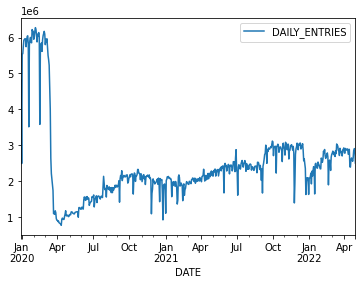

In [32]:
temp = (df[(df.DATE.dt.dayofweek > 5)&(df.LINE_DENSITY < 100000000)]
    .groupby('DATE').sum())
# temp = df.groupby('DATE').sum()
temp.reset_index().plot.line('DATE','DAILY_ENTRIES')

In [33]:
new = pd.read_csv('COVID-19_Daily_Counts_of_Cases__Hospitalizations__and_Deaths.csv')
new.head()
new['DATE'] = pd.to_datetime(new.DATE_OF_INTEREST)

out = pd.merge(temp,new, on=['DATE', 'DATE'])
out.head()


,DATE,DAILY_ENTRIES,DAILY_EXITS,LINE_DENSITY,DATE_OF_INTEREST,CASE_COUNT,probable_case_count,HOSPITALIZED_COUNT,DEATH_COUNT,DEATH_COUNT_PROBABLE,...,si_probable_case_count,SI_HOSPITALIZED_COUNT,SI_DEATH_COUNT,si_probable_death_count,SI_CASE_COUNT_7DAY_AVG,si_all_case_count_7day_avg,SI_HOSPITALIZED_COUNT_7DAY_AVG,SI_DEATH_COUNT_7DAY_AVG,si_all_death_count_7day_avg,INCOMPLETE
0,2020-03-02,5.800782e+06,4.782892e+06,5.767836e+06,03/02/2020,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-03-03,5.949893e+06,4.897650e+06,5.941836e+06,03/03/2020,1,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-03-04,5.871575e+06,4.827888e+06,5.932377e+06,03/04/2020,5,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-03-05,5.964128e+06,4.959136e+06,5.960966e+06,03/05/2020,3,0,14,0,0,...,0,1,0,0,0,0,0,0,0,0
4,2020-03-06,5.745054e+06,4.733035e+06,5.739800e+06,03/06/2020,8,0,8,0,0,...,0,1,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='DATE'>

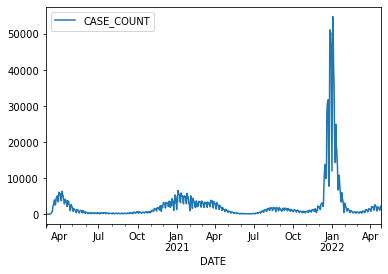

In [17]:
out.plot.line('DATE','CASE_COUNT')

In [26]:
import matplotlib.pyplot as plt

In [48]:
temp.DATE =pd.to_datetime(temp.DATE)

In [56]:
temp.reset_index(inplace= True)
temp['Week'] = temp.DATE.dt.week
temp['Year'] = temp.DATE.dt.year
temp.head()

AttributeError: 'DataFrame' object has no attribute 'DATE'

In [53]:
out = out[out.DATE > pd.to_datetime('2020-05-01')]

In [66]:
temp.head()

,level_0,Year,Week,index,DAILY_ENTRIES,DAILY_EXITS,LINE_DENSITY
0,0,2019,1,226268.627615,9864.861571,8333.712398,9712.836733
1,1,2019,52,225956.251046,6749.112568,6008.220454,6323.998135
2,2,2020,1,182369.507750,8117.228759,6857.463963,7888.669958
3,3,2020,2,183391.267585,10663.539991,8765.936873,10480.680383
4,4,2020,3,184320.519581,10492.236598,8718.240616,10376.905379


In [44]:
temp = load_pickle('data_merged/mta_data_corrected')
out = temp.groupby(pd.Grouper(key='DATE', freq='W-MON')).mean()


KeyError: 'The grouper name DATE is not found'

In [ ]:

# plt.figure(figsize=(4,12))

fig, ax = plt.subplots(figsize=(12,4))


# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx(), ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# Move the last y-axis spine over to the right by 20% of the width of the axes
# axes[-1].spines['right'].set_position(('axes', 1.2))

# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

# And finally we get to plot things...
colors = ('Red', 'Blue')
i=0
# df = df[df.DAILY_ENTRIES<1000000]
for ax, color in zip(axes, colors):
    if i ==0 :
        ax.plot(out.DATE,out.DAILY_EXITS, color=color)
        ax.set_ylabel('Daily Exits')
    else: 
        ax.plot(out.DATE,out.CASE_COUNT, color=color)
        ax.set_ylabel('Daily Cases')
    # ax.set_ylabel('%s Thing' % color, color=color)
    ax.tick_params(axis='y', colors=color)
    i+= 1
axes[0].set_xlabel('Date')


plt.show()

In [42]:
print(f'Correlation between Subway Entries and Covid Cases:\t{out.DAILY_ENTRIES.corr(out.CASE_COUNT)}')
print(f'Correlation between Subway Exits and Covid Cases:\t{out.DAILY_EXITS.corr(out.CASE_COUNT)}')
print(f'Correlation between Line Density and Covid Cases:\t{out.LINE_DENSITY.corr(out.CASE_COUNT)}')

Correlation between Subway Entries and Covid Cases:	-0.05292688589404249
Correlation between Subway Exits and Covid Cases:	0.024942241560296764
Correlation between Line Density and Covid Cases:	-0.006785332684427975


In [51]:
for x in range(-7,0):
    print(f'Correlation between Line Density and Covid Cases:\t{out.LINE_DENSITY.shift(x).corr(out.CASE_COUNT.iloc[:x])}')

Correlation between Line Density and Covid Cases:	-0.0015245479317690274
Correlation between Line Density and Covid Cases:	-0.0042604150156090054
Correlation between Line Density and Covid Cases:	-0.008675139141025462
Correlation between Line Density and Covid Cases:	-0.026189160003137986
Correlation between Line Density and Covid Cases:	-0.0275008050125912
Correlation between Line Density and Covid Cases:	-0.025770944709397517
Correlation between Line Density and Covid Cases:	-0.01871878134460754


In [52]:
for x in range(1,7):
    print(f'Correlation between Line Density and Covid Cases:\t{out.LINE_DENSITY.shift(x).corr(out.CASE_COUNT.iloc[:-x])}')

Correlation between Line Density and Covid Cases:	-0.01882748361250583
Correlation between Line Density and Covid Cases:	-0.00624458576232121
Correlation between Line Density and Covid Cases:	0.010572682166831831
Correlation between Line Density and Covid Cases:	0.03208655832443489
Correlation between Line Density and Covid Cases:	0.05240986510675581
Correlation between Line Density and Covid Cases:	0.06535899194050879


## 3a
- ### Each Row represents one recording for one turnstile

In [47]:
bor = pd.read_html('https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_stations', 'November 1, 1933' )[0]

/tmp/ipykernel_3148/980312259.py:1: FutureWarning: Starting with pandas version 2.0 all arguments of read_html except for the argument 'io' will be keyword-only.
  bor = pd.read_html('https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_stations', 'November 1, 1933' )[0]


In [119]:
bor.head()

,Station,Services,Div,Line,Opened,Borough,Neighborhood,Ridership (2019),Rank
0,First Avenue,NaN,BMT,.mw-parser-output .legend{page-break-inside:av...,"June 30, 1924",Manhattan,East Village,5345371,83
1,Second Avenue,NaN,IND,Sixth Avenue Line,"January 1, 1936",Manhattan,East Village,5583944,79
2,Third Avenue,NaN,BMT,Carnarsie Line,"June 30, 1924",Manhattan,East Village,1700456,275
3,Third Avenue–138th Street,NaN,IRT,Pelham Line,"August 1, 1918",The Bronx,Mott Haven,2503850,190
4,Third Avenue–149th Street,NaN,IRT,White Plains Road Line,"July 10, 1905",The Bronx,Mott Haven,6768255,59


In [142]:
print(df.STATION[~ df.STATION.isin(bor.Station)].unique())
print(bor.Station[~ bor.Station.isin(df.STATION)].unique())


['BEVERLY RD' 'EASTCHSTER/DYRE' 'FLATBUSH AV-B.C' 'NEWKIRK AV'
 'PRESIDENT ST' 'RIT-MANHATTAN' 'RIT-ROOSEVELT' 'ST. GEORGE'
 'SUTTER AV-RUTLD' 'TOMPKINSVILLE' 'ORCHARD BEACH' '103 ST' '116 ST'
 '125 ST' '135 ST' '14 ST' '145 ST' '155 ST' '163 ST-AMSTERDM' '168 ST'
 '175 ST' '34 ST-PENN STA' '42 ST-PORT AUTH' '59 ST COLUMBUS' '72 ST'
 '80 ST' '81 ST-MUSEUM' '88 ST' '96 ST' 'BROADWAY JCT' 'CATHEDRAL PKWY'
 'CLINTON-WASH AV' 'EUCLID AV' 'FRANKLIN AV' 'HOYT-SCHER'
 'KINGSTON-THROOP' 'OZONE PK LEFFRT' 'ROCKAWAY BLVD' 'VAN SICLEN AVE'
 'W 4 ST-WASH SQ' 'WORLD TRADE CTR' '15 ST-PROSPECT' '169 ST' '2 AV'
 '21 ST' '21 ST-QNSBRIDGE' '4 AV-9 ST' '42 ST-BRYANT PK' '47-50 STS ROCK'
 '57 ST' '72 ST-2 AVE' '86 ST-2 AVE' '96 ST-2 AVE' 'AVENUE I' 'AVENUE N'
 'AVENUE P' 'AVENUE X' "B'WAY-LAFAYETTE" 'BEDFORD-NOSTRAN' 'COURT SQ'
 'JAMAICA 179 ST' 'JAMAICA CENTER' 'JAMAICA VAN WK' 'LEXINGTON AV/63'
 'MYRTLE-WILLOUGH' 'NEWARK HW BMEBE' 'PARSONS BLVD' 'ROOSEVELT ISLND'
 'SMITH-9 ST' 'SUTPHIN BLVD' 'SUTPHIN-A

- ### Find Max Entries for each unqiue turnstile everyday

In [100]:
max_entries = df.groupby(['DATE','STATION','SCP'])['ENTRIES'].max()
max_entries

DATE        STATION    SCP     
08/27/2016  1 AV       00-00-00     11450095
                       00-00-01     56095346
                       00-03-00    369691349
                       00-03-01      1698399
                       00-03-02      5241027
                                     ...    
09/16/2016  ZEREGA AV  00-00-01       144602
                       00-03-00       295370
                       00-03-01       491847
                       00-05-00           46
                       00-05-01           39
Name: ENTRIES, Length: 84520, dtype: int64

- ### Correct Entry Amounts to account for cumulative nature
    Entries are accumulated overtime. Therefore they are not reset each day.
    To get a representative number of entries at each turnstile each day take the number of entries at the end of the day - the number at the beginning of the day

In [101]:
min_entries = df.groupby(['DATE','STATION','SCP'])['ENTRIES'].min()
corrected_entries = max_entries - min_entries
corrected_entries

DATE        STATION    SCP     
08/27/2016  1 AV       00-00-00    1935
                       00-00-01    2671
                       00-03-00     452
                       00-03-01     399
                       00-03-02     788
                                   ... 
09/16/2016  ZEREGA AV  00-00-01     360
                       00-03-00     787
                       00-03-01    1299
                       00-05-00       0
                       00-05-01       0
Name: ENTRIES, Length: 84520, dtype: int64

## 3b
   - ### Try Different Methods for calculating entries

In [33]:
max_entries = df.groupby(['DATE','STATION','SCP'])['ENTRIES'].last()
min_entries = df.groupby(['DATE','STATION','SCP'])['ENTRIES'].first()
corrected_entries = max_entries - min_entries
corrected_entries

DATE        STATION    SCP     
08/27/2016  1 AV       00-00-00    1935
                       00-00-01    2671
                       00-03-00     452
                       00-03-01     399
                       00-03-02     788
                                   ... 
09/16/2016  ZEREGA AV  00-00-01     360
                       00-03-00     787
                       00-03-01    1299
                       00-05-00       0
                       00-05-01       0
Name: ENTRIES, Length: 84520, dtype: int64

   - ### Check Values to see if they make sense
       - They do not...

In [95]:
corrected_entries.describe()

count    8.452000e+04
mean     4.817043e+06
std      1.175331e+08
min     -2.023383e+09
25%      1.260000e+02
50%      6.510000e+02
75%      1.432000e+03
max      2.018634e+09
Name: ENTRIES, dtype: float64

   - ### Another Method
       - I am confused

In [128]:
df['ENTRIES_PREV'] = df.groupby(['STATION','SCP'])['ENTRIES'].shift(1)
df.dropna(inplace = True)
df['ENTRIES_CORRECTED'] = df['ENTRIES'] - df['ENTRIES_PREV']
corrected_entries = df[['DATE','STATION','SCP', 'ENTRIES_CORRECTED']]
corrected_entries.describe()

,ENTRIES_CORRECTED
count,5.768640e+05
mean,3.293299e+04
std,2.616024e+07
min,-2.023381e+09
25%,1.100000e+01
50%,7.600000e+01
75%,2.400000e+02
max,2.023379e+09


## 4
   - ### View Entries At Station Level

In [104]:
corrected_entries.groupby(['STATION']).sum()

STATION
1 AV                    331878
103 ST              1161681202
103 ST-CORONA           357818
104 ST             66080497327
110 ST                  199394
                      ...     
WOODHAVEN BLVD      2425203529
WOODLAWN                125963
WORLD TRADE CTR         238900
YORK ST                 174855
ZEREGA AV                43001
Name: ENTRIES, Length: 374, dtype: int64

## 5
   - ### View entries at the daily level for each station

In [105]:
corrected_entries.groupby(['DATE','STATION']).sum()

DATE        STATION        
08/27/2016  1 AV                    12685
            103 ST               55300040
            103 ST-CORONA           14038
            104 ST             3146693474
            110 ST                   7079
                                  ...    
09/16/2016  WOODHAVEN BLVD      115474260
            WOODLAWN                 7353
            WORLD TRADE CTR         14507
            YORK ST                  9961
            ZEREGA AV                2781
Name: ENTRIES, Length: 7832, dtype: int64

## 6
  - ### Find Stations With The Highest Traffic

In [108]:
corrected_entries.groupby(['STATION']).sum().sort_values(ascending=False)

STATION
23 ST              124697720325
125 ST             120240003982
42 ST-PORT AUTH    116154656937
CANAL ST            92383363323
TIMES SQ-42 ST      76117770516
                       ...     
BEACH 105 ST               7151
BROAD CHANNEL              5519
ORCHARD BEACH              1939
SARATOGA AV                  25
PATH NEW WTC                  1
Name: ENTRIES, Length: 374, dtype: int64